In [2]:
import os, glob, gc, copy, math, random, time, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from tqdm import tqdm

# ══════════════════════════ KONFIGURASI ══════════════════════════
DATA_DIR    = "/workspace/SPLIT_BEATS_NPY/train"
LABEL_MAP   = {'N':0,'L':1,'R':2,'V':3,'Q':4}
SEED        = 42
N_SPLITS    = 5
EPOCHS      = 1
BATCH_SIZE  = 16
MAX_LEN     = 512
EMB_DIM     = 512
N_HEADS     = 8
FF_DIM      = 2048
N_LAYERS    = 12
LR          = 2e-5
OUTPUT_BASE = "/workspace/HASIL_DECODER/HASIL_1"
os.makedirs(OUTPUT_BASE, exist_ok=True)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_ID, CLS_ID  = 256, 257
VOCAB_SIZE      = 258
cls_names       = list(LABEL_MAP.keys())

# ══════════ UTILITAS ══════════

def signal_to_ids(sig: np.ndarray):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    ids  = np.concatenate(([CLS_ID], norm))[:MAX_LEN]
    mask = np.ones_like(ids, dtype=int)
    if len(ids) < MAX_LEN:
        pad_len = MAX_LEN - len(ids)
        ids  = np.concatenate((ids,  np.full(pad_len, PAD_ID)))
        mask = np.concatenate((mask, np.zeros(pad_len)))
    return ids, mask

# ══════════ MUAT DATA ══════════
files, labels = [], []
for cls, idx in LABEL_MAP.items():
    for f in glob.glob(os.path.join(DATA_DIR, cls, "*.npy")):
        files.append(f); labels.append(idx)
files, labels = np.array(files), np.array(labels)

all_ids, all_mask = [], []
for f in tqdm(files, desc="Pre-encoding"):
    ids, msk = signal_to_ids(np.load(f))
    all_ids.append(ids);  all_mask.append(msk)
all_ids  = torch.tensor(all_ids,  dtype=torch.long)
all_mask = torch.tensor(all_mask, dtype=torch.long)
labels_t = torch.tensor(labels,   dtype=torch.long)

# ══════════ DEFINISI DECODER-ONLY ══════════
class DecoderOnlyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM, padding_idx=PAD_ID)
        self.pos_emb   = nn.Parameter(torch.zeros(1, MAX_LEN, EMB_DIM))
        dec_layer = nn.TransformerDecoderLayer(d_model=EMB_DIM, nhead=N_HEADS,
                                               dim_feedforward=FF_DIM, dropout=0.1,
                                               batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=N_LAYERS)
        self.fc      = nn.Linear(EMB_DIM, len(LABEL_MAP))
        nn.init.normal_(self.pos_emb, std=0.02)

    def forward(self, input_ids, attention_mask):
        tgt = self.token_emb(input_ids) + self.pos_emb
        memory = torch.zeros_like(tgt).to(tgt.device)  # dummy memory
        x = self.decoder(tgt, memory, tgt_key_padding_mask=~attention_mask.bool())
        x = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True).clamp(min=1e-9)
        return self.fc(x)

# ══════════ K-FOLD TRAINING ══════════
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
rows_all = []

for fold, (tr, va) in enumerate(skf.split(all_ids, labels), 1):
    print(f"\n==== FOLD {fold}/{N_SPLITS} ====")
    gc.collect(); torch.cuda.empty_cache()

    train_ds = TensorDataset(all_ids[tr], all_mask[tr], labels_t[tr])
    val_ds   = TensorDataset(all_ids[va], all_mask[va], labels_t[va])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

    model = DecoderOnlyClassifier().to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, EPOCHS)

    best_state, best_loss = None, math.inf
    out_dir = os.path.join(OUTPUT_BASE, f"fold{fold}"); os.makedirs(out_dir, exist_ok=True)

    for epoch in range(1, EPOCHS + 1):
        print(f"\U0001f552 Fold {fold} | Epoch {epoch}/{EPOCHS}")
        model.train(); total_loss = 0.0
        for ids, msk, lbl in tqdm(train_loader, leave=False):
            ids, msk, lbl = ids.to(DEVICE), msk.to(DEVICE), lbl.to(DEVICE)
            optim.zero_grad(); out = model(ids, msk)
            loss = F.cross_entropy(out, lbl)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step(); total_loss += loss.item()
        scheduler.step()

        model.eval(); val_loss, preds, yh = 0.0, [], []
        with torch.no_grad():
            for ids, msk, lbl in val_loader:
                ids, msk, lbl = ids.to(DEVICE), msk.to(DEVICE), lbl.to(DEVICE)
                out = model(ids, msk)
                val_loss += F.cross_entropy(out, lbl, reduction='sum').item()
                preds.append(out.argmax(1).cpu()); yh.append(lbl.cpu())
        val_loss /= len(val_ds)
        if val_loss < best_loss:
            best_loss, best_state = val_loss, copy.deepcopy(model.state_dict())
        print(f"ValLoss={val_loss:.4f}")

    # Simpan model dan config
    torch.save(best_state, os.path.join(out_dir, "best_model.pt"))
    with open(os.path.join(out_dir, "model_config.json"), "w") as f:
        json.dump({"emb_dim":EMB_DIM,"n_layers":N_LAYERS,"n_heads":N_HEADS,"ff_dim":FF_DIM,
                   "max_len":MAX_LEN,"vocab_size":VOCAB_SIZE,"pad_id":PAD_ID,"cls_id":CLS_ID,
                   "label_map":LABEL_MAP}, f, indent=2)
    with open(os.path.join(out_dir, "vocab.txt"), "w") as f:
        f.writelines([f"{i}\n" for i in range(256)] + ["[PAD]\n","[CLS]\n"])

    # Evaluasi dan confusion matrix
    model.load_state_dict(best_state); model.eval()
    with torch.no_grad():
        logits = []; y_true = []
        for ids, msk, lbl in val_loader:
            ids, msk = ids.to(DEVICE), msk.to(DEVICE)
            logits.append(model(ids, msk).cpu()); y_true.append(lbl)
    preds = torch.cat(logits).argmax(1).numpy(); y_true = torch.cat(y_true).numpy()

    cm = confusion_matrix(y_true, preds, labels=list(range(len(cls_names))))
    for i, cls in enumerate(cls_names):
        TP = cm[i,i]; FN = cm[i].sum()-TP; FP = cm[:,i].sum()-TP; TN = cm.sum()-TP-FN-FP
        ACC = (TP+TN)/cm.sum(); REC = TP/(TP+FN+1e-8)
        SPEC = TN/(TN+FP+1e-8); F1 = 2*TP/(2*TP+FP+FN+1e-8)
        rows_all.append({"fold":fold, "kelas":cls, "akurasi":round(ACC,4),
                         "f1":round(F1,4), "recall":round(REC,4), "spesifisitas":round(SPEC,4)})

    # Simpan confusion matrix gambar
    plt.figure(figsize=(7,6)); plt.imshow(cm, cmap='Blues')
    plt.title(f"Confusion Fold {fold}")
    plt.xticks(range(len(cls_names)), cls_names)
    plt.yticks(range(len(cls_names)), cls_names)
    for r in range(len(cm)):
        for c in range(len(cm)):
            plt.text(c, r, cm[r,c], ha='center', va='center')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "confusion_fold.png"))
    plt.close()

# Simpan semua metrik
pd.DataFrame(rows_all).to_csv(os.path.join(OUTPUT_BASE, "final_summary_perkelas.csv"), index=False)
print("\n✔️ Training selesai. Semua hasil disimpan.")


Pre-encoding: 100%|██████████| 28000/28000 [00:03<00:00, 7486.37it/s]



==== FOLD 1/5 ====


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 23.58 GiB of which 16.44 MiB is free. Process 71901 has 10.64 GiB memory in use. Process 236872 has 8.58 GiB memory in use. Process 309636 has 4.33 GiB memory in use. Of the allocated memory 4.02 GiB is allocated by PyTorch, and 15.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

C:\Users\Asus\AppData\Local\Temp\ipykernel_16476\919539223.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  test_ids = torch.tensor(all_ids, dtype=torch.long)



===== Evaluasi Per Kelas =====
  Kelas   Akurasi    Recall  F1-Score  Spesifisitas
0     N  0.965143  0.892857  0.911079      0.983214
1     L  0.976714  0.962143  0.942947      0.980357
2     R  0.985571  0.959286  0.963760      0.992143
3     V  0.970857  0.942857  0.928270      0.977857
4     Q  0.985429  0.952143  0.963150      0.993750

===== Rata-rata Metrik Keseluruhan =====
Akurasi         0.976743
Recall          0.941857
F1-Score        0.941841
Spesifisitas    0.985464
dtype: float64


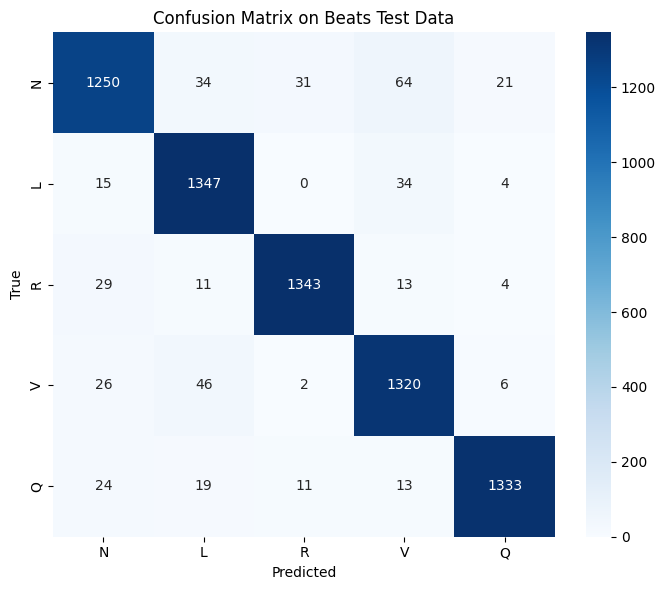

In [2]:
import os, json, torch, numpy as np, pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

# ====== KONFIGURASI ======
TEST_DIR = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\SPLIT_BEATS_NPY\Beats_TEST"
MODEL_PATH =r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_DECODER\HASIL_2\fold3\best_model.pt"  # Pilih model fold terbaik
CONFIG_PATH = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\HASIL_DECODER\HASIL_2\fold3\model_config.json"
LABEL_MAP = {'N':0, 'L':1, 'R':2, 'V':3, 'Q':4}
PAD_ID, CLS_ID = 256, 257
MAX_LEN = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Load config ======
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

EMB_DIM = config['emb_dim']
N_LAYERS = config['n_layers']
N_HEADS = config['n_heads']
FF_DIM = config['ff_dim']
VOCAB_SIZE = config['vocab_size']

cls_names = list(LABEL_MAP.keys())

# ====== Signal to IDs ======
def signal_to_ids(sig: np.ndarray):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    ids  = np.concatenate(([CLS_ID], norm))[:MAX_LEN]
    mask = np.ones_like(ids, dtype=int)
    if len(ids) < MAX_LEN:
        pad_len = MAX_LEN - len(ids)
        ids  = np.concatenate((ids,  np.full(pad_len, PAD_ID)))
        mask = np.concatenate((mask, np.zeros(pad_len)))
    return ids, mask

# ====== Dataset Loading ======
files, labels = [], []
for cls, idx in LABEL_MAP.items():
    cls_dir = os.path.join(TEST_DIR, cls)
    for file in os.listdir(cls_dir):
        if file.endswith('.npy'):
            files.append(os.path.join(cls_dir, file))
            labels.append(idx)

all_ids, all_mask = [], []
for f in files:
    ids, msk = signal_to_ids(np.load(f))
    all_ids.append(ids)
    all_mask.append(msk)

test_ids = torch.tensor(all_ids, dtype=torch.long)
test_mask = torch.tensor(all_mask, dtype=torch.long)
test_labels = torch.tensor(labels, dtype=torch.long)

test_ds = TensorDataset(test_ids, test_mask, test_labels)
test_loader = DataLoader(test_ds, batch_size=16)

# ====== Model Definition ======
import torch.nn as nn

class DecoderOnlyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM, padding_idx=PAD_ID)
        self.pos_emb   = nn.Parameter(torch.zeros(1, MAX_LEN, EMB_DIM))
        dec_layer = nn.TransformerDecoderLayer(d_model=EMB_DIM, nhead=N_HEADS,
                                               dim_feedforward=FF_DIM, dropout=0.1,
                                               batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=N_LAYERS)
        self.fc      = nn.Linear(EMB_DIM, len(LABEL_MAP))
        nn.init.normal_(self.pos_emb, std=0.02)

    def forward(self, input_ids, attention_mask):
        tgt = self.token_emb(input_ids) + self.pos_emb
        memory = torch.zeros_like(tgt).to(tgt.device)
        x = self.decoder(tgt, memory, tgt_key_padding_mask=~attention_mask.bool())
        x = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True).clamp(min=1e-9)
        return self.fc(x)

# ====== Load Model ======
model = DecoderOnlyClassifier().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ====== Inference ======
all_preds, all_labels = [], []
with torch.no_grad():
    for ids, msk, lbl in test_loader:
        ids, msk = ids.to(device), msk.to(device)
        out = model(ids, msk)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(lbl.numpy())

cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(cls_names))))

# ====== Evaluasi Per Kelas ======
results_per_class = []
for i, cls in enumerate(cls_names):
    TP = cm[i,i]
    FN = cm[i].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = cm.sum() - TP - FP - FN

    acc = (TP + TN) / cm.sum()
    rec = TP / (TP + FN + 1e-8)
    spec = TN / (TN + FP + 1e-8)
    f1 = 2*TP / (2*TP + FP + FN + 1e-8)

    results_per_class.append([cls, acc, rec, f1, spec])

df_per_class = pd.DataFrame(results_per_class, columns=["Kelas", "Akurasi", "Recall", "F1-Score", "Spesifisitas"])
print("\n===== Evaluasi Per Kelas =====")
print(df_per_class)

# ====== Rata-rata Metrik ======
avg_metrics = df_per_class[['Akurasi','Recall','F1-Score','Spesifisitas']].mean()
print("\n===== Rata-rata Metrik Keseluruhan =====")
print(avg_metrics)

# ====== Save hasil ======
OUTPUT_DIR = os.path.dirname(MODEL_PATH)
df_per_class.to_csv(os.path.join(OUTPUT_DIR, "hasil_test_perkelas.csv"), index=False)
avg_metrics.to_csv(os.path.join(OUTPUT_DIR, "hasil_test_ratarata.csv"))

# ====== Plot Confusion Matrix ======
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cls_names, yticklabels=cls_names)
plt.title("Confusion Matrix on Beats Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confmat_test.png"))
plt.show()